In [1]:
% matplotlib inline
print("Hello, HW 01!")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

Hello, HW 01!


## kNN not normalized

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist


def prepare_data_notnorm(filename='spambase.csv'):
    df = pd.read_csv(filename)
    objects, labels = df.iloc[:, :-1], df.iloc[:, -1]
    return objects, labels


# return accuracy
def classify(objects, labels, k) -> float:
    assert k >= 0 and objects is not None

    # dist between every pair of points
    dists = cdist(objects, objects)

    # from every row of distances get indices of k smallest distances
    idx = np.argpartition(dists, k, axis=1)[:,
          1:k + 1]  # 1:k+1 because [0] index is elem himself

    # Labels to array
    arr_labels = labels.values

    # Lables для 3х ближайших соседей
    nearest_dists = np.take(arr_labels, idx)

    # Number of label=1 among all neigbours for every testObject
    counted = nearest_dists.sum(axis=1)
    #     counted

    predicted = np.array((counted > k / 2), dtype=int)
    #     predicted

    accuracy = np.equal(predicted, arr_labels).sum() / arr_labels.shape[0]

    return accuracy


################
def simple_kNN(objects, labels):
    ks = [k for k in range(1, 11)]
    accuracy = []

    for k in ks:
        acc = classify(objects, labels, k)
        accuracy.append(acc)

    return ks, accuracy


#### inteface ###
def kNN_not_normalized():
    objects, labels = prepare_data_notnorm()
    x, y = simple_kNN(objects, labels)
    
    print("max acc = " + repr(max(y)))
    print("it's K  = " + repr(x[y.index(max(y))]))

    plt.ylabel('LOO')
    plt.xlabel('K')

    red_patch = mpatches.Patch(color='red', label='kNN not normalizaed')
    plt.legend(handles=[red_patch])

    plt.plot(x, y, label='kNN not normalizaed', color='red')
    plt.show()


max acc = 0.84242555966094324
it's K  = 3


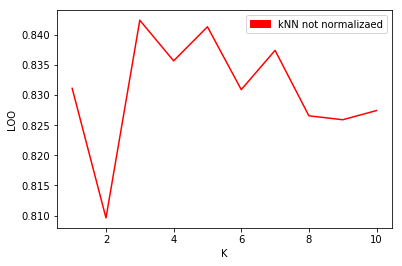

In [11]:
kNN_not_normalized()

### Нормализуем kNN

In [3]:
def prepare_data_norm(filename='spambase.csv'):
    df = pd.read_csv(filename)
    objects, labels = df.iloc[:, :-1], df.iloc[:, -1]

    def normalizer(s):
        return (s - s.min()) / (s.max() - s.min())

    return objects.apply(normalizer, axis=0), labels


#### inteface ###
def kNN_normalized():
    objects, labels = prepare_data_norm()
    x, y = simple_kNN(objects, labels)
    
    print("max acc = " + repr(max(y)))
    print("it's K  = " + repr(x[y.index(max(y))]))

    plt.ylabel('LOO')
    plt.xlabel('K')
    lb = 'kNN normalizaed'

    red_patch = mpatches.Patch(color='blue', label=lb)
    plt.legend(handles=[red_patch])

    plt.plot(x, y, label=lb, color='blue')
    plt.show()


max acc = 0.9180612910236905
it's K  = 3


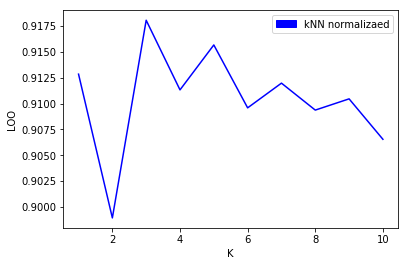

In [15]:
kNN_normalized()

## Radius neighbours
### Not normalized
Тернарный поиск после, внизу.

In [4]:
# return accuracy
def classify_radius(objects, labels, r) -> float:
    assert r > 0 and objects is not None

    from scipy.spatial.distance import cdist

    # dist between every points
    dists = cdist(objects, objects)

    # маска с соседями, которые внутр радиуса
    # каждая строка - битовый вектор--маска тех элементов, которые внутри радиуса
    # and not id - для того, чтобы убить себя -- главную диагональ
    bools_vert_in_radius = \
        np.logical_and(
            (dists < r),
            ~np.identity(dists.shape[0],
                         dtype=bool))

    # вектор -- число вершин внутри радиуса для каждой точке
    vert_in_radius = bools_vert_in_radius.sum(axis=1)

    # разможим labels чтобы дальше считать без циклов для каждой
    # тестовой вершины
    labelsRep = (labels.values.repeat(dists.shape[0])
                 .reshape(dists.shape[1], dists.shape[0])).T

    # для каждого теста - сколько соседей c label=1 имеют одна тестова вершина
    labels_for_each_test = np.logical_and(labelsRep, bools_vert_in_radius).sum(
        axis=1)

    predicted = np.array(labels_for_each_test > (vert_in_radius / 2),
                         dtype=int)

    accuracy = \
        np.equal(predicted, labels.values).sum() / labels.values.shape[0]

    return accuracy


################
def radius_kNN(objects, labels, r, maximum, step, verbose=True):
    if verbose:
        dists = cdist(objects, objects)
        print("min dist = " + repr(np.min(dists)))
        print("max dist = " + repr(np.max(dists)))

    rs = []
    accuracy = []

    while r <= maximum:
        acc = classify_radius(objects, labels, r)
        accuracy.append(acc)
        rs.append(r)
        r += step

    return rs, accuracy


#### inteface ###
def kNN_radius_not_normalized(r=1.0, maximum=177.0, step=15.0):
    objects, labels = prepare_data_notnorm()
    x, y = radius_kNN(objects, labels, r, maximum, step)

    print()
    print("max acc = " + repr(max(y)))
    print("it's R  = " + repr(x[y.index(max(y))]))

    plt.ylabel('LOO')
    plt.xlabel('R')
    lbl = 'kNN Radius not normalizaed'

    red_patch = mpatches.Patch(color='red', label=lbl)
    plt.legend(handles=[red_patch])

    plt.plot(x, y, label=lbl, color='red')
    plt.show()


Сначала глазами найдём границы для тернарного поиска

min dist = 0.0
max dist = 15840.015903596752

max acc = 0.73223212345142363
it's R  = 20.1


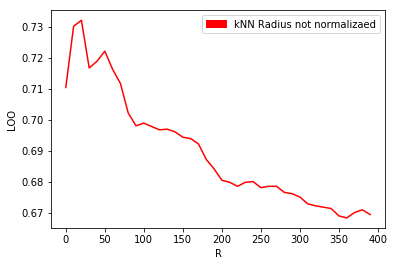

In [50]:
kNN_radius_not_normalized(0.1, 400, 10)

min dist = 0.0
max dist = 15840.015903596752

max acc = 0.76505107585307541
it's R  = 4.1


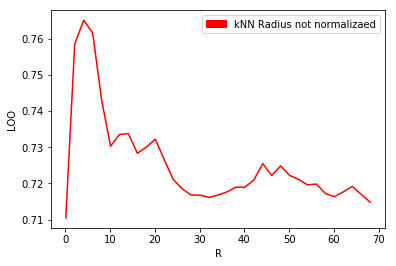

In [51]:
# kNN_radius_not_normalized(left, right, step)
kNN_radius_not_normalized(0.1, 70, 2)

min dist = 0.0
max dist = 15840.015903596752

max acc = 0.77135405346663766
it's R  = 5.299999999999998


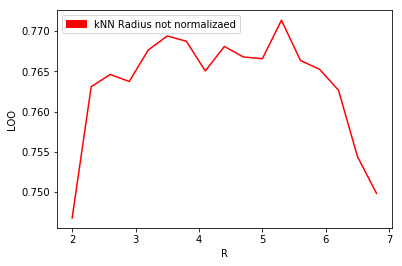

In [27]:
kNN_radius_not_normalized(2, 7, 0.3)

### Тренарный поиск radius not normalized
Вот тут можно запускать уже.

In [5]:
def trenary_search(preparer, classifier, left, right, eps):
    objects, labels = preparer()
    
    next_r = left + (right - left) / 2
    if right - left < eps:
        return next_r, classifier(objects, labels, next_r)
    a = left  + (right - left) / 3 
    b = right - (right - left) / 3
#     left a b right
    acc_a = classifier(objects, labels, a)
    acc_b = classifier(objects, labels, b)
    if acc_a > acc_b:
        return trenary_search(preparer, classifier, left, b, eps)
    else:
        return trenary_search(preparer, classifier, a, right, eps)

In [37]:
opt_normal_r, opt_acc = trenary_search(prepare_data_notnorm, classify_radius, 5, 5.6, 0.05)
print("optimal r = " + str(opt_normal_r))
print("opt acc = " + str(opt_acc))

optimal r = 5.542935528120713
opt acc = 0.771788741578


## Radius Normalized

In [6]:
#### inteface ###
def kNN_radius_normalized(r = 1.0, maximum = 177.0, step = 15.0):
    objects, labels = prepare_data_norm()
    x, y = radius_kNN(objects, labels, r, maximum, step)

    print()
    print("max acc = " + repr(max(y)))
    print("it's R  = " + repr(x[y.index(max(y))]))
    
    plt.ylabel('LOO')
    plt.xlabel('R')
    lb = 'kNN radius normalizaed'
    
    red_patch = mpatches.Patch(color='blue', label=lb)
    plt.legend(handles=[red_patch])


    plt.plot(x, y, label=lb, color='blue')
    plt.show() 
    

min dist = 0.0
max dist = 2.7947019207026766

max acc = 0.83829602260378178
it's R  = 0.21000000000000002


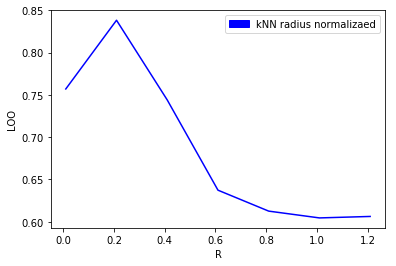

In [41]:
kNN_radius_normalized(0.01, 1.4, 0.2)

min dist = 0.0
max dist = 2.7947019207026766

max acc = 0.83916539882634211
it's R  = 0.20500000000000007


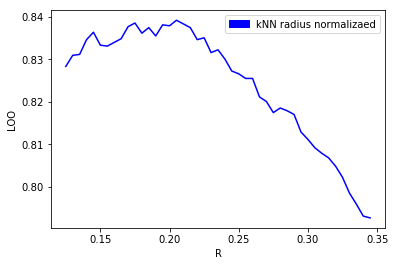

In [42]:
kNN_radius_normalized(0.125, 0.35, 0.005)

min dist = 0.0
max dist = 2.7947019207026766

max acc = 0.83916539882634211
it's R  = 0.20500000000000004


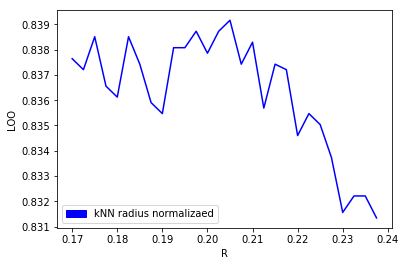

In [43]:
kNN_radius_normalized(0.17, 0.24, 0.0025)

### Тернарный поиск normalized radius

In [45]:
opt_normal_r, opt_acc = trenary_search(prepare_data_norm, classify_radius, 0.202, 0.209, 0.0003)
print("optomal r = " + str(opt_normal_r))
print("opt acc = " + str(opt_acc))

optomal r = 0.20553147386069198
opt acc = 0.839600086938


## WkNN normalized
Я очень не уверен, что понимю его правильно (а то графики какие-то любопытные выходят)

In [7]:
############################################################################
# return accuracy
def classify_w(objects, labels, k, r) -> float:
    assert k >= 0 and objects is not None

    # dist between every pair of points
    dists = cdist(objects, objects)

    # Labels to array
    arr_labels = labels.values

#   # ТУТ формула для весов
    weights = np.maximum(np.zeros(dists.shape), (r - dists) / r)

    # from every row of distances get indices of k smallest distances
    # индексы k ближайших соседей    
    idx = np.argpartition(dists, k, axis=1)[:,
          1:k + 1]  # 1:k+1 because [0] index is elem himself

    # веса k ближайших соседей
    nearest_weights = np.take(weights, idx)

    # count weigths for all neigbours -- сумма весов всех соседей
    weights_sum_all = nearest_weights.sum(axis=1)

    # get mask of labels ones
    # get mask for nearest weights, which labels are ones ?
    ones_mask = np.take(labels.values, idx) > 0

    # So, now count  for neighbours with label=1 -- сумма весов соседей 
    # с label=1
    weights_sum_label_ones = np.where(ones_mask, nearest_weights, 0).sum(
        axis=1)

    # если сумма весов соседей с label=1 больше половины суммы весов всех соседей - то label=1
    # Так ведь?
    predicted = np.array((weights_sum_label_ones > weights_sum_all / 2),
                         dtype=int)

    accuracy = np.equal(predicted, arr_labels).sum() / arr_labels.shape[0]

    return accuracy


################
def w_kNN(objects, labels, k, r, maximum, step, verbose=True):
    if verbose:
        dists = cdist(objects, objects)
        print("min dist = " + repr(np.min(dists)))
        print("max dist = " + repr(np.max(dists)))

    rs = []
    accuracy = []

    while r <= maximum:
        acc = classify_w(objects, labels, k, r)
        accuracy.append(acc)
        rs.append(r)
        r += step

    return rs, accuracy


#### inteface ###
def WkNN_radius_normalized(k=3, r=1.0, maximum=177.0, step=15.0):
    objects, labels = prepare_data_norm()
    x, y = w_kNN(objects, labels, k, r, maximum, step)

    print("K = " + str(k))
    print("max acc = " + repr(max(y)))
    print("it's R  = " + repr(x[y.index(max(y))]))

    plt.ylabel('LOO')
    plt.xlabel('r')
    lbl = 'WkNN normalizaed'

    red_patch = mpatches.Patch(color='blue', label=lbl)
    plt.legend(handles=[red_patch])

    plt.plot(x, y, label=lbl, color='blue')
    plt.show()

Возьмем k=3 и найдем хороший r.
Знаем макисмальный dist, посмотрим, каким может быть r

min dist = 0.0
max dist = 2.7947019207026766
K = 3
max acc = 0.9180612910236905
it's R  = 1.2009999999999998


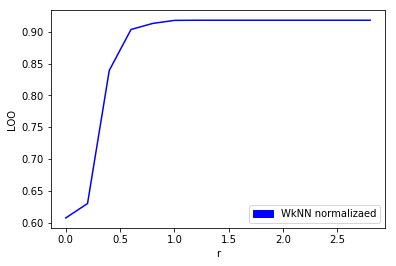

In [38]:
WkNN_radius_normalized(k=3, r=0.001, maximum=3, step=0.2)

min dist = 0.0
max dist = 2.7947019207026766
K = 3
max acc = 0.9180612910236905
it's R  = 1.0999999999999999


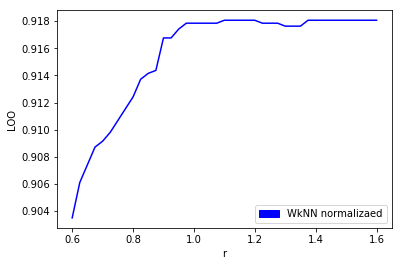

In [45]:
WkNN_radius_normalized(k=3, r=0.60, maximum=1.60, step=0.025)


In [53]:
r = 1.099

## Try NOT normalized WkNN

In [9]:
#### inteface ###
def WkNN_radius_notnormalized(k=3, r=0.1, maximum=25.0, step=3.0):
    objects, labels = prepare_data_notnorm()
    x, y = w_kNN(objects, labels, k, r, maximum, step)

    print("K = " + str(k))
    print("max acc = " + repr(max(y)))
    print("it's R  = " + repr(x[y.index(max(y))]))

    plt.ylabel('LOO')
    plt.xlabel('r')
    lbl = 'WkNN not normalized'

    red_patch = mpatches.Patch(color='red', label=lbl)
    plt.legend(handles=[red_patch])

    plt.plot(x, y, label=lbl, color='red')
    plt.show()

min dist = 0.0
max dist = 15840.015903596752
K = 3
max acc = 0.84242555966094324
it's R  = 15000.1


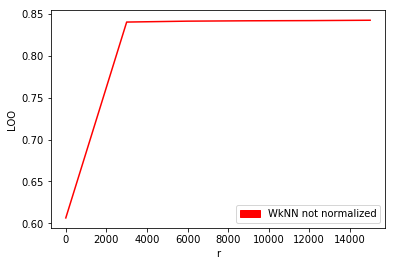

In [10]:
WkNN_radius_notnormalized(k=3, r=0.1, maximum=15840.0, step=3000.0)

min dist = 0.0
max dist = 15840.015903596752
K = 3
max acc = 0.84177352749402301
it's R  = 3250.0


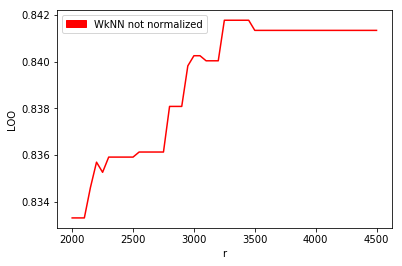

In [11]:
WkNN_radius_notnormalized(k=3, r=2000, maximum=4500, step=50.0)

min dist = 0.0
max dist = 15840.015903596752
K = 3
max acc = 0.84177352749402301
it's R  = 3260.0


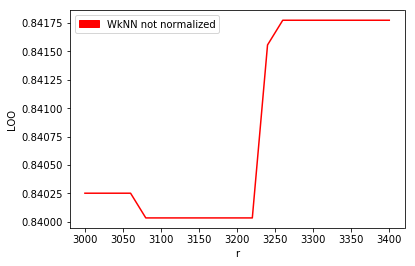

In [12]:
WkNN_radius_notnormalized(k=3, r=3000, maximum=3400, step=20.0)

r = 3260 